In [1]:
import pandas as pd
import numpy as np

In [2]:
# Viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import PercentFormatter

In [3]:
# List of commodities available in OWID
commodities = [
               'Aluminum', 'Antinomy', 
               'Bismuth',
               'Chromium','Cobalt', 'Copper',
               'Fluorspar',
               'Gallium', 'Germanium', 'Graphite',
               'Helium',
               'Iridium','Iron', 'Iron_ore', 
               'Lithium',
               'Magnesium_compounds', 'Magnesium_metal', 'Manganese', 'Molybdenum', 
               'Nickel', 'Niobium', 
               'Palladium','PGMs', 'Platinum', 'Potash',
               'REEs', 'Rhodium', 'Ruthenium',
               'Silicon', 
               'Tantalum', 'Tin', 'Titanium', 'Tungsten', 
               'Uranium', 
               'Vanadium',
               'Zinc'
]

In [4]:
from pathlib import Path
import os 

In [9]:
for com in commodities:
    print(os.path.join('.', com))

.\Aluminum
.\Antinomy
.\Bismuth
.\Chromium
.\Cobalt
.\Copper
.\Fluorspar
.\Gallium
.\Germanium
.\Graphite
.\Helium
.\Iridium
.\Iron
.\Iron_ore
.\Lithium
.\Magnesium_compounds
.\Magnesium_metal
.\Manganese
.\Molybdenum
.\Nickel
.\Niobium
.\Palladium
.\PGMs
.\Platinum
.\Potash
.\REEs
.\Rhodium
.\Ruthenium
.\Silicon
.\Tantalum
.\Tin
.\Titanium
.\Tungsten
.\Uranium
.\Vanadium
.\Zinc


# Graphs for all commodities 

In [10]:
def create_graphs_for_commodities(commodities):
    for commodity in commodities:
        print(f"Processing {commodity}...")
        
        # Define file paths
        commodity_dir = os.path.join('data/USGS/OWID', commodity)
        reserves_file = os.path.join(commodity_dir, f'{commodity.lower()}_reserves.csv')
        production_types = ['mine', 'refinery', 'processing', 'smelter']
        production_files = {ptype: os.path.join(commodity_dir, f'{commodity.lower()}_production_{ptype}.csv') for ptype in production_types}

        # Load reserves data
        try:
            reserves_df = pd.read_csv(reserves_file)
        except FileNotFoundError:
            print(f"Reserves file {reserves_file} not found. Skipping reserves analysis.")
            reserves_df = None

        # Load production data
        production_data = {}
        for ptype, pfile in production_files.items():
            try:
                production_data[ptype] = pd.read_csv(pfile)
            except FileNotFoundError:
                print(f"Production file {pfile} not found. Skipping {ptype} production analysis.")

        if not production_data and reserves_df is None:
            print(f"No data found for {commodity}. Skipping to next commodity.")
            continue

        # Create graphs
        fig, axes = plt.subplots(1, len(production_data) + (1 if reserves_df is not None else 0), figsize=(8 * (len(production_data) + (1 if reserves_df is not None else 0)), 8))
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        ax_index = 0

        # Define colors
        world_color = '#003049'
        canada_color = '#d62828'
        top3_color = '#ffba49'

        # Reserves plot
        if reserves_df is not None:
            latest_year_reserves = reserves_df['Year'].max()
            latest_reserves = reserves_df[reserves_df['Year'] == latest_year_reserves]
            
            # Check if 'World' data exists
            if 'World' in latest_reserves['Entity'].values:
                world_reserves = latest_reserves[latest_reserves['Entity'] == 'World'].iloc[0, -1]
            else:
                # Sum all countries if 'World' data does not exist
                world_reserves = latest_reserves.iloc[:, -1].sum()
            
            top3_reserves = latest_reserves[latest_reserves['Entity'] != 'World'].nlargest(3, latest_reserves.columns[-1])
            canada_reserves = latest_reserves[latest_reserves['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_reserves['Entity'].values else 0
            
            # Plot world and Canada
            sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
            
            # Calculate top 3 share and percentages relative to World
            top3_percentage = top3_reserves.iloc[:, -1].sum() / world_reserves * 100
            top3_reserve_value = top3_reserves.iloc[:, -1].sum()
            canada_percentage = canada_reserves / world_reserves * 100
            
            # Calculate individual country shares for Top 3
            top3_countries = "\n".join([f"{row['Entity']}: {row.iloc[-1] / world_reserves * 100:.1f}%" for _, row in top3_reserves.iterrows()])
            
            # Update the legend with Canada and Top 3 percentages
            axes[ax_index].scatter(0, top3_reserve_value, s=200, color=top3_color, zorder=3, label=f'Top 3: {top3_percentage:.1f}% ({top3_countries})')
            axes[ax_index].legend([f'Canada: {canada_percentage:.1f}%\nTop 3: {top3_percentage:.1f}% ({top3_countries})'], loc='upper right', fontsize=10)

            axes[ax_index].set_title(f'{commodity} Reserves (Latest Year: {latest_year_reserves})', fontsize=16, fontweight='bold')
            axes[ax_index].set_ylabel(reserves_df.columns[-1], fontsize=12, fontstyle='italic')
            axes[ax_index].set_xlabel('', fontsize=12, fontstyle='italic')
            axes[ax_index].tick_params(axis='both', which='major', labelsize=10)
            
            # Add Canadian flag representation
            rect = Rectangle((0.9, 0), 0.2, canada_reserves, facecolor='white', edgecolor='black', linewidth=1, zorder=3)
            axes[ax_index].add_patch(rect)
            axes[ax_index].text(1, canada_reserves/2, '', ha='center', va='center', fontsize=20, zorder=4)
            
            ax_index += 1

        # Production plots
        for ptype, pdata in production_data.items():
            latest_year_production = pdata['Year'].max()
            latest_production = pdata[pdata['Year'] == latest_year_production]
            
            # Check if 'World' data exists
            if 'World' in latest_production['Entity'].values:
                world_production = latest_production[latest_production['Entity'] == 'World'].iloc[0, -1]
            else:
                # Sum all countries if 'World' data does not exist
                world_production = latest_production.iloc[:, -1].sum()
            
            top3_production = latest_production[latest_production['Entity'] != 'World'].nlargest(3, latest_production.columns[-1])
            canada_production = latest_production[latest_production['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_production['Entity'].values else 0
            
            sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
            
            # Calculate top 3 share and percentages relative to World
            top3_percentage = top3_production.iloc[:, -1].sum() / world_production * 100
            top3_production_value = top3_production.iloc[:, -1].sum()
            canada_percentage = canada_production / world_production * 100
            
            # Calculate individual country shares for Top 3
            top3_countries = "\n".join([f"{row['Entity']}: {row.iloc[-1] / world_production * 100:.1f}%" for _, row in top3_production.iterrows()])
            
            # Update the legend with Canada and Top 3 percentages
            axes[ax_index].scatter(0, top3_production_value, s=200, color=top3_color, zorder=3, label=f'Top 3: {top3_percentage:.1f}% ({top3_countries})')
            axes[ax_index].legend([f'Canada: {canada_percentage:.1f}%\nTop 3: {top3_percentage:.1f}% ({top3_countries})'], loc='upper right', fontsize=10)

            axes[ax_index].set_title(f'{commodity} {ptype.capitalize()} Production (Latest Year: {latest_year_production})', fontsize=16, fontweight='bold')
            axes[ax_index].set_ylabel(pdata.columns[-1], fontsize=12, fontstyle='italic')
            axes[ax_index].set_xlabel('', fontsize=12, fontstyle='italic')
            axes[ax_index].tick_params(axis='both', which='major', labelsize=10)
            
            # Add Canadian flag representation
            rect = Rectangle((0.9, 0), 0.2, canada_production, facecolor='white', edgecolor='black', linewidth=1, zorder=3)
            axes[ax_index].add_patch(rect)
            axes[ax_index].text(1, canada_production/2, '', ha='center', va='center', fontsize=20, zorder=4)
            
            ax_index += 1

        plt.tight_layout()
        plt.savefig(os.path.join(commodity_dir, f'{commodity.lower()}_latest_year_graphs.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # Evolution of production
        plt.figure(figsize=(12, 8))
        for ptype, pdata in production_data.items():
            production_since_2010 = pdata[pdata['Year'] >= 2010]
            world_production_per_year = production_since_2010.groupby('Year').sum().reset_index()
            canada_production_per_year = production_since_2010[production_since_2010['Entity'] == 'Canada'][['Year', pdata.columns[-1]]]
            
            plt.plot(world_production_per_year['Year'], world_production_per_year.iloc[:, -1], label=f'World ({ptype})', marker='o', color=world_color)
            plt.plot(canada_production_per_year['Year'], canada_production_per_year.iloc[:, -1], label=f'Canada ({ptype})', marker='o', color=canada_color)

        plt.title(f'Evolution of {commodity} Production (2010 - Latest Year)', fontsize=16, fontweight='bold')
        plt.xlabel('Year', fontsize=12, fontstyle='italic')
        plt.ylabel(f'Production ({pdata.columns[-1]})', fontsize=12, fontstyle='italic')  # Include unit in ylabel
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.savefig(os.path.join(commodity_dir, f'{commodity.lower()}_production_evolution.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f'Graphs for {commodity} created and saved.')



In [11]:
create_graphs_for_commodities(commodities)

Processing Aluminum...
Reserves file data/USGS/OWID\Aluminum\aluminum_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Aluminum\aluminum_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Aluminum\aluminum_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Aluminum\aluminum_production_processing.csv not found. Skipping processing production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Aluminum created and saved.
Processing Antinomy...
Production file data/USGS/OWID\Antinomy\antinomy_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Antinomy\antinomy_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Antinomy\antinomy_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Antinomy created and saved.
Processing Bismuth...
Reserves file data/USGS/OWID\Bismuth\bismuth_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Bismuth\bismuth_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Bismuth\bismuth_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Bismuth created and saved.
Processing Chromium...
Production file data/USGS/OWID\Chromium\chromium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Chromium\chromium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Chromium\chromium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Chromium created and saved.
Processing Cobalt...
Production file data/USGS/OWID\Cobalt\cobalt_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Cobalt\cobalt_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

Graphs for Cobalt created and saved.
Processing Copper...
Production file data/USGS/OWID\Copper\copper_production_processing.csv not found. Skipping processing production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

Graphs for Copper created and saved.
Processing Fluorspar...
Production file data/USGS/OWID\Fluorspar\fluorspar_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Fluorspar\fluorspar_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Fluorspar\fluorspar_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Fluorspar created and saved.
Processing Gallium...
Reserves file data/USGS/OWID\Gallium\gallium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Gallium\gallium_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Gallium\gallium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Gallium created and saved.
Processing Germanium...
Reserves file data/USGS/OWID\Germanium\germanium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Germanium\germanium_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Germanium\germanium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Germanium\germanium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Germanium created and saved.
Processing Graphite...
Production file data/USGS/OWID\Graphite\graphite_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Graphite\graphite_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Graphite\graphite_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Graphite created and saved.
Processing Helium...
Production file data/USGS/OWID\Helium\helium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Helium\helium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Helium\helium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Helium created and saved.
Processing Iridium...
Reserves file data/USGS/OWID\Iridium\iridium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Iridium\iridium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Iridium\iridium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Iridium\iridium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Iridium created and saved.
Processing Iron...
Reserves file data/USGS/OWID\Iron\iron_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Iron\iron_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Iron\iron_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Iron\iron_production_processing.csv not found. Skipping processing production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Iron created and saved.
Processing Iron_ore...
Reserves file data/USGS/OWID\Iron_ore\iron_ore_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Iron_ore\iron_ore_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Iron_ore\iron_ore_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Iron_ore\iron_ore_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Iron_ore\iron_ore_production_smelter.csv not found. Skipping smelter production analysis.
No data found for Iron_ore. Skipping to next commodity.
Processing Lithium...
Production file data/USGS/OWID\Lithium\lithium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Lithium\lithium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Li

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Lithium created and saved.
Processing Magnesium_compounds...
Production file data/USGS/OWID\Magnesium_compounds\magnesium_compounds_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Magnesium_compounds\magnesium_compounds_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Magnesium_compounds\magnesium_compounds_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Magnesium_compounds created and saved.
Processing Magnesium_metal...
Reserves file data/USGS/OWID\Magnesium_metal\magnesium_metal_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Magnesium_metal\magnesium_metal_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Magnesium_metal\magnesium_metal_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Magnesium_metal\magnesium_metal_production_processing.csv not found. Skipping processing production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Magnesium_metal created and saved.
Processing Manganese...
Production file data/USGS/OWID\Manganese\manganese_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Manganese\manganese_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Manganese\manganese_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Manganese created and saved.
Processing Molybdenum...
Production file data/USGS/OWID\Molybdenum\molybdenum_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Molybdenum\molybdenum_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Molybdenum\molybdenum_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Molybdenum created and saved.
Processing Nickel...
Production file data/USGS/OWID\Nickel\nickel_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Nickel\nickel_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

Graphs for Nickel created and saved.
Processing Niobium...
Production file data/USGS/OWID\Niobium\niobium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Niobium\niobium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Niobium\niobium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Niobium created and saved.
Processing Palladium...
Reserves file data/USGS/OWID\Palladium\palladium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Palladium\palladium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Palladium\palladium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Palladium\palladium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Palladium created and saved.
Processing PGMs...
Reserves file data/USGS/OWID\PGMs\pgms_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\PGMs\pgms_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\PGMs\pgms_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\PGMs\pgms_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for PGMs created and saved.
Processing Platinum...
Production file data/USGS/OWID\Platinum\platinum_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Platinum\platinum_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Platinum\platinum_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Platinum created and saved.
Processing Potash...
Production file data/USGS/OWID\Potash\potash_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Potash\potash_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Potash\potash_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Potash created and saved.
Processing REEs...
Production file data/USGS/OWID\REEs\rees_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\REEs\rees_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\REEs\rees_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for REEs created and saved.
Processing Rhodium...
Reserves file data/USGS/OWID\Rhodium\rhodium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Rhodium\rhodium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Rhodium\rhodium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Rhodium\rhodium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Rhodium created and saved.
Processing Ruthenium...
Reserves file data/USGS/OWID\Ruthenium\ruthenium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Ruthenium\ruthenium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Ruthenium\ruthenium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Ruthenium\ruthenium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Ruthenium created and saved.
Processing Silicon...
Reserves file data/USGS/OWID\Silicon\silicon_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Silicon\silicon_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Silicon\silicon_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Silicon\silicon_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Silicon created and saved.
Processing Tantalum...
Production file data/USGS/OWID\Tantalum\tantalum_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Tantalum\tantalum_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Tantalum\tantalum_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Tantalum created and saved.
Processing Tin...
Production file data/USGS/OWID\Tin\tin_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Tin\tin_production_processing.csv not found. Skipping processing production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

Graphs for Tin created and saved.
Processing Titanium...
Reserves file data/USGS/OWID\Titanium\titanium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Titanium\titanium_production_mine.csv not found. Skipping mine production analysis.
Production file data/USGS/OWID\Titanium\titanium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Titanium\titanium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Titanium\titanium_production_smelter.csv not found. Skipping smelter production analysis.
No data found for Titanium. Skipping to next commodity.
Processing Tungsten...
Production file data/USGS/OWID\Tungsten\tungsten_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Tungsten\tungsten_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWI

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Tungsten created and saved.
Processing Uranium...
Reserves file data/USGS/OWID\Uranium\uranium_reserves.csv not found. Skipping reserves analysis.
Production file data/USGS/OWID\Uranium\uranium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Uranium\uranium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Uranium\uranium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Uranium created and saved.
Processing Vanadium...
Production file data/USGS/OWID\Vanadium\vanadium_production_refinery.csv not found. Skipping refinery production analysis.
Production file data/USGS/OWID\Vanadium\vanadium_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Vanadium\vanadium_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])


Graphs for Vanadium created and saved.
Processing Zinc...
Production file data/USGS/OWID\Zinc\zinc_production_processing.csv not found. Skipping processing production analysis.
Production file data/USGS/OWID\Zinc\zinc_production_smelter.csv not found. Skipping smelter production analysis.


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_reserves, canada_reserves], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['World', 'Canada'], y=[world_production, canada_production], ax=axes[ax_index], palette=[world_color, canada_color])
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\901856961.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

Graphs for Zinc created and saved.


# Graphs with thresholds

In [15]:
def filter_and_plot_commodities_by_threshold(commodities, threshold):
    data_list = []
    filtered_commodities = []  # List to store commodities that meet the threshold

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # One for production, one for reserves
    ax_prod, ax_res = axes
    
    # Define colors
    world_color = '#003049'
    canada_color = '#d62828'
    width = 0.35  # Width of the bars
    
    for i, commodity in enumerate(commodities):
        print(f"Processing {commodity}...")
        
        # Define file paths
        commodity_dir = os.path.join('data/USGS/OWID', commodity) 
        reserves_file = os.path.join(commodity_dir, f'{commodity.lower()}_reserves.csv')
        production_types = ['mine', 'refinery', 'processing', 'smelter']
        production_files = {ptype: os.path.join(commodity_dir, f'{commodity.lower()}_production_{ptype}.csv') for ptype in production_types}

        # Load reserves data
        try:
            reserves_df = pd.read_csv(reserves_file)
        except FileNotFoundError:
            print(f"Reserves file {reserves_file} not found. Skipping reserves analysis.")
            reserves_df = None

        # Load production data
        production_data = {}
        for ptype, pfile in production_files.items():
            try:
                production_data[ptype] = pd.read_csv(pfile)
            except FileNotFoundError:
                print(f"Production file {pfile} not found. Skipping {ptype} production analysis.")
        
        # Proceed even if no data is found to ensure all commodities are included in the dataframe
        latest_year_reserves = reserves_df['Year'].max() if reserves_df is not None else None
        latest_reserves = reserves_df[reserves_df['Year'] == latest_year_reserves] if reserves_df is not None and not reserves_df.empty else None

        # Filter production data for the latest year
        latest_year_production = {}
        latest_production = {}

        for ptype, pdata in production_data.items():
            if not pdata.empty:
                latest_year_production[ptype] = pdata['Year'].max()
                latest_production[ptype] = pdata[pdata['Year'] == latest_year_production[ptype]]

        canada_reserves = 0
        if reserves_df is not None and latest_reserves is not None and not latest_reserves.empty:
            if 'World' in latest_reserves['Entity'].values:
                world_reserves = latest_reserves[latest_reserves['Entity'] == 'World'].iloc[0, -1]
            else:
                world_reserves = latest_reserves.iloc[:, -1].sum()

            canada_reserves = latest_reserves[latest_reserves['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_reserves['Entity'].values else 0
            canada_reserves_percentage = canada_reserves / world_reserves * 100 if world_reserves > 0 else 0
        else:
            world_reserves = 0
            canada_reserves_percentage = 0
        
        canada_production_percentage = {}
        for ptype, pdata in latest_production.items():
            if not pdata.empty:
                if 'World' in pdata['Entity'].values:
                    world_production = pdata[pdata['Entity'] == 'World'].iloc[0, -1]
                else:
                    world_production = pdata.iloc[:, -1].sum()

                canada_production = pdata[pdata['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in pdata['Entity'].values else 0
                canada_production_percentage[ptype] = canada_production / world_production * 100 if world_production > 0 else 0
            else:
                canada_production_percentage[ptype] = 0
                world_production = 0

        # Collect data for the dataframe for all commodities
        data_row = {
            'Commodity': commodity,
            'Reserves (Canada)': canada_reserves,
            'Reserves (World)': world_reserves,
            'Reserves (%)': canada_reserves_percentage
        }

        # Add production data for each production type
        for ptype in production_types:
            if ptype in canada_production_percentage:
                data_row[f'{ptype.capitalize()} Production (Canada)'] = latest_production[ptype][latest_production[ptype]['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_production[ptype]['Entity'].values else 0
                data_row[f'{ptype.capitalize()} Production (World)'] = latest_production[ptype][latest_production[ptype]['Entity'] == 'World'].iloc[0, -1] if 'World' in latest_production[ptype]['Entity'].values else 0
                data_row[f'{ptype.capitalize()} Production (%)'] = canada_production_percentage[ptype]
            else:
                data_row[f'{ptype.capitalize()} Production (Canada)'] = None
                data_row[f'{ptype.capitalize()} Production (World)'] = None
                data_row[f'{ptype.capitalize()} Production (%)'] = None

        data_list.append(data_row)

        # Check if the commodity meets the threshold for reserves or any production type
        if (canada_reserves_percentage >= threshold or any(pct >= threshold for pct in canada_production_percentage.values())):
            filtered_commodities.append(commodity)
            
            # Plot reserves data
            if reserves_df is not None and latest_reserves is not None and not latest_reserves.empty:
                idx = len(filtered_commodities) - 1  # Index for filtered commodities
                ax_res.bar([idx - width/2], [world_reserves], width, color=world_color)
                ax_res.bar([idx + width/2], [canada_reserves], width, color=canada_color)
            
            # Plot production data for each type separately
            for ptype, pct in canada_production_percentage.items():
                if ptype in latest_production and not latest_production[ptype].empty:
                    idx = len(filtered_commodities) - 1
                    world_prod_value = latest_production[ptype][latest_production[ptype]['Entity'] == 'World'].iloc[0, -1] if 'World' in latest_production[ptype]['Entity'].values else 0
                    canada_prod_value = latest_production[ptype][latest_production[ptype]['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_production[ptype]['Entity'].values else 0
                    
                    ax_prod.bar([idx - width/2], [world_prod_value], width, color=world_color)
                    ax_prod.bar([idx + width/2], [canada_prod_value], width, color=canada_color)

    # Adjust axes and titles to include the threshold
    ax_res.set_title(f'World and Canadian reserves for {threshold}% threshold', fontsize=16)
    ax_res.set_ylabel('Reserves in tonnes', fontsize=14)
    ax_res.set_xticks(range(len(filtered_commodities)))
    ax_res.set_xticklabels(filtered_commodities, rotation=45, ha="right", fontsize=14)
    
    ax_prod.set_title(f'World and Canadian production for {threshold}% threshold', fontsize=16)
    ax_prod.set_ylabel('Production in tonnes', fontsize=14)
    ax_prod.set_xticks(range(len(filtered_commodities)))
    ax_prod.set_xticklabels(filtered_commodities, rotation=45, ha="right", fontsize=14)
    
    # Set a single legend for both axes, placing it inside the graphs
    handles = [plt.Rectangle((0,0),1,1, color=world_color), plt.Rectangle((0,0),1,1, color=canada_color)]
    labels = ['World', 'Canada']
    ax_res.legend(handles, labels, loc='upper right', fontsize=16)  # Placing legend inside the reserves graph
    ax_prod.legend(handles, labels, loc='upper right', fontsize=16)  # Placing legend inside the production graph

    plt.tight_layout()
    plt.savefig(f'CMs_threshold_{threshold}.png', format='png', dpi=300)
    plt.show()
    
    # Create the dataframe and display it
    df = pd.DataFrame(data_list)
    return df



In [34]:
import pandas as pd
import os

def filter_commodities_by_threshold_2(commodities):
    data_list = []
    filtered_commodities = []  # List to store commodities that meet the threshold

    for i, commodity in enumerate(commodities):
        print(f"Processing {commodity}...")
        
        # Define file paths
        commodity_dir = os.path.join('data/USGS/OWID', commodity) 
        reserves_file = os.path.join(commodity_dir, f'{commodity.lower()}_reserves.csv')
        production_types = ['mine', 'refinery', 'processing', 'smelter']
        production_files = {ptype: os.path.join(commodity_dir, f'{commodity.lower()}_production_{ptype}.csv') for ptype in production_types}

        # Load reserves data
        try:
            reserves_df = pd.read_csv(reserves_file)
        except FileNotFoundError:
            print(f"Reserves file {reserves_file} not found.")
            reserves_df = None

        # Load production data
        production_data = {}
        for ptype, pfile in production_files.items():
            try:
                production_data[ptype] = pd.read_csv(pfile)
            except FileNotFoundError:
                print(f"Production file {pfile} not found.")
        
        # Extract the latest year of data
        latest_year_reserves = reserves_df['Year'].max() if reserves_df is not None else None
        latest_reserves = reserves_df[reserves_df['Year'] == latest_year_reserves] if reserves_df is not None and not reserves_df.empty else None

        # Initialize reserves as None to distinguish missing data
        canada_reserves = None
        world_reserves = None
        canada_reserves_percentage = None

        if latest_reserves is not None and not latest_reserves.empty:
            # Calculate world reserves if available
            world_reserves = latest_reserves[latest_reserves['Entity'] == 'World'].iloc[0, -1] if 'World' in latest_reserves['Entity'].values else latest_reserves.iloc[:, -1].sum()

            # Calculate Canada reserves if available
            canada_reserves = latest_reserves[latest_reserves['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_reserves['Entity'].values else None

            # Calculate Canada reserves as a percentage of world reserves if both are available
            canada_reserves_percentage = (canada_reserves / world_reserves * 100) if world_reserves and canada_reserves else None
        
        # Filter production data for the latest year
        latest_year_production = {}
        latest_production = {}
        canada_production_percentage = {}

        for ptype, pdata in production_data.items():
            if not pdata.empty:
                latest_year_production[ptype] = pdata['Year'].max()
                latest_production[ptype] = pdata[pdata['Year'] == latest_year_production[ptype]]
                
                # Calculate production percentages
                world_production = latest_production[ptype][latest_production[ptype]['Entity'] == 'World'].iloc[0, -1] if 'World' in latest_production[ptype]['Entity'].values else latest_production[ptype].iloc[:, -1].sum()
                canada_production = latest_production[ptype][latest_production[ptype]['Entity'] == 'Canada'].iloc[0, -1] if 'Canada' in latest_production[ptype]['Entity'].values else None
                canada_production_percentage[ptype] = (canada_production / world_production * 100) if world_production and canada_production else None
            else:
                canada_production_percentage[ptype] = None
                latest_production[ptype] = None

        # Collect data for the dataframe for all commodities
        data_row = {
            'Commodity': commodity,
            'Reserves (Canada)': canada_reserves,
            'Reserves (World)': world_reserves,
            'Reserves (%)': canada_reserves_percentage
        }

        # Add production data for each production type
        for ptype in production_types:
            if ptype in canada_production_percentage:
                canada_value = latest_production[ptype][latest_production[ptype]['Entity'] == 'Canada'].iloc[0, -1] if latest_production[ptype] is not None and 'Canada' in latest_production[ptype]['Entity'].values else None
                world_value = latest_production[ptype][latest_production[ptype]['Entity'] == 'World'].iloc[0, -1] if latest_production[ptype] is not None and 'World' in latest_production[ptype]['Entity'].values else None
                data_row[f'{ptype.capitalize()} Production (Canada)'] = canada_value
                data_row[f'{ptype.capitalize()} Production (World)'] = world_value
                data_row[f'{ptype.capitalize()} Production (%)'] = canada_production_percentage[ptype]
            else:
                data_row[f'{ptype.capitalize()} Production (Canada)'] = None
                data_row[f'{ptype.capitalize()} Production (World)'] = None
                data_row[f'{ptype.capitalize()} Production (%)'] = None

        data_list.append(data_row)

    # Create the dataframe and display it
    df = pd.DataFrame(data_list)
    return df


In [35]:
# Example usage with a 5% threshold
df = filter_commodities_by_threshold_2(commodities)
df

Processing Aluminum...
Reserves file data/USGS/OWID\Aluminum\aluminum_reserves.csv not found.
Production file data/USGS/OWID\Aluminum\aluminum_production_mine.csv not found.
Production file data/USGS/OWID\Aluminum\aluminum_production_refinery.csv not found.
Production file data/USGS/OWID\Aluminum\aluminum_production_processing.csv not found.
Processing Antinomy...
Production file data/USGS/OWID\Antinomy\antinomy_production_refinery.csv not found.
Production file data/USGS/OWID\Antinomy\antinomy_production_processing.csv not found.
Production file data/USGS/OWID\Antinomy\antinomy_production_smelter.csv not found.
Processing Bismuth...
Reserves file data/USGS/OWID\Bismuth\bismuth_reserves.csv not found.
Production file data/USGS/OWID\Bismuth\bismuth_production_processing.csv not found.
Production file data/USGS/OWID\Bismuth\bismuth_production_smelter.csv not found.
Processing Chromium...
Production file data/USGS/OWID\Chromium\chromium_production_refinery.csv not found.
Production file d

,Commodity,Reserves (Canada),Reserves (World),Reserves (%),Mine Production (Canada),Mine Production (World),Mine Production (%),Refinery Production (Canada),Refinery Production (World),Refinery Production (%),Processing Production (Canada),Processing Production (World),Processing Production (%),Smelter Production (Canada),Smelter Production (World),Smelter Production (%)
0,Aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000000.0,7.000000e+07,4.285714
1,Antinomy,7.800000e+04,2.171000e+06,3.592814,2.000000e+00,83000.0,0.002410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bismuth,NaN,NaN,NaN,NaN,8480.0,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chromium,NaN,5.600000e+08,NaN,NaN,41000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cobalt,2.300000e+05,1.100000e+07,2.090909,2.100000e+03,230000.0,0.913043,5501.0,NaN,3.412023,NaN,NaN,NaN,NaN,NaN,NaN
5,Copper,7.600000e+06,1.000000e+09,0.760000,4.800000e+05,22000000.0,2.181818,310000.0,27000000.0,1.148148,NaN,NaN,NaN,288600.0,NaN,1.383159
6,Fluorspar,NaN,2.800000e+08,NaN,NaN,8800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gallium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434.0,NaN,NaN,610.0,NaN,NaN,NaN,NaN
8,Germanium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Graphite,5.700000e+06,2.800000e+08,2.035714,3.500000e+03,1600000.0,0.218750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\1327642116.py:43: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\1327642116.py:44: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  plt.savefig('graphs/reserves_and_production_heatmap.png', format='png', dpi=300)
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


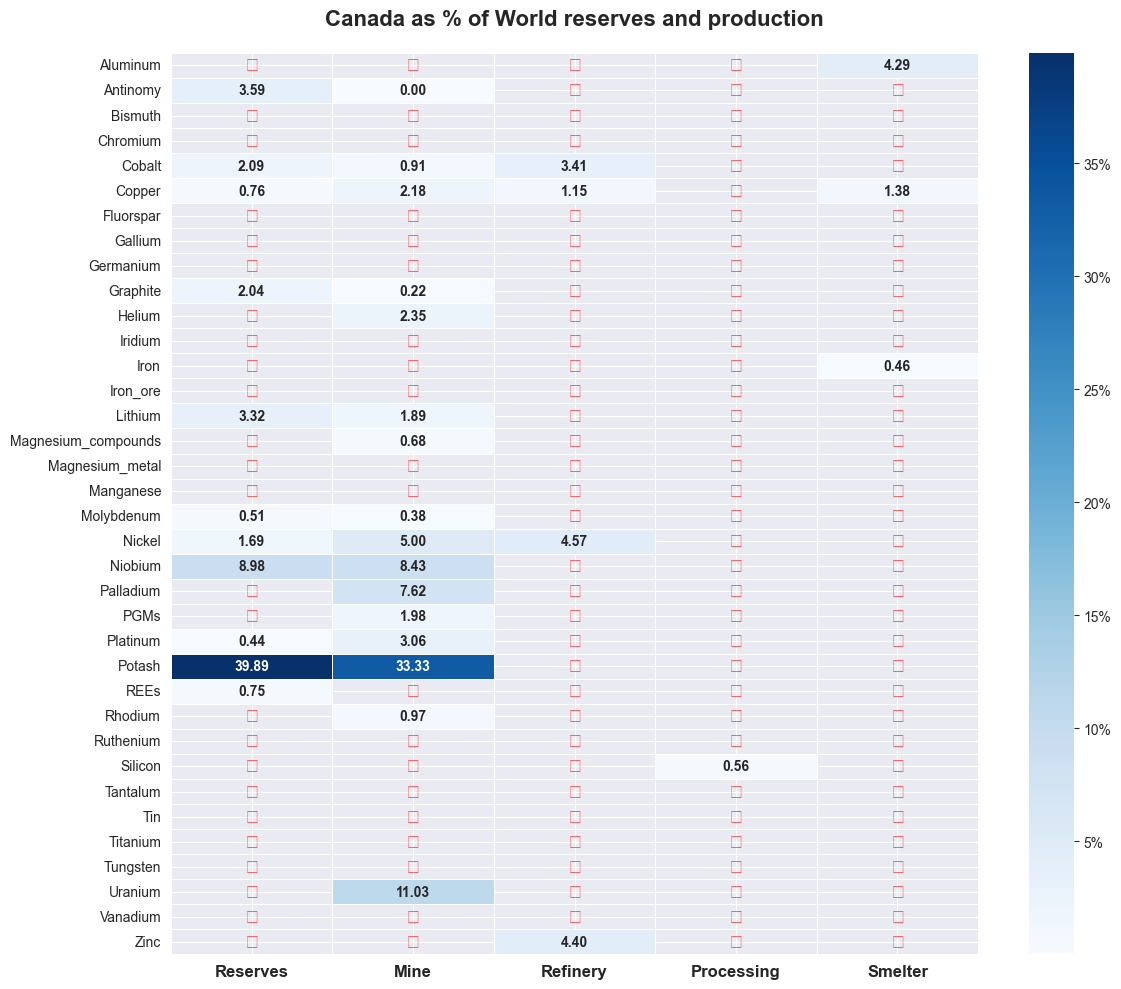

In [36]:
# Define the relevant percentage columns
percentage_columns = [
    'Reserves (%)', 
    'Mine Production (%)', 
    'Refinery Production (%)', 
    'Processing Production (%)', 
    'Smelter Production (%)'
]

# Extract only the relevant columns and keep NaNs intact
df_percentages = df[['Commodity'] + percentage_columns].set_index('Commodity')

# Rename the columns to simplify their labels
df_percentages.rename(columns={
    'Reserves (%)': 'Reserves', 
    'Mine Production (%)': 'Mine', 
    'Refinery Production (%)': 'Refinery', 
    'Processing Production (%)': 'Processing', 
    'Smelter Production (%)': 'Smelter'
}, inplace=True)

# Create a heatmap without filling NaNs
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_percentages, annot=True, cmap="Blues", fmt=".2f", linewidths=.5, cbar_kws={'format': '%.0f%%'},
                      annot_kws={"size": 10, "weight": "bold"}, mask=df_percentages.isna())

# Overlay crosses on NaN cells by iterating through each cell in the DataFrame
for i in range(df_percentages.shape[0]):
    for j in range(df_percentages.shape[1]):
        if pd.isna(df_percentages.iloc[i, j]):  # Check if the cell is NaN
            heatmap.text(j + 0.5, i + 0.5, '✕', color='red', ha='center', va='center', fontsize=14, fontweight='bold')

# Customize x-axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, fontweight='bold')

# Remove the y-axis label 'Commodity'
heatmap.set_ylabel('')

# Set the title with more space using the 'pad' argument
plt.title('Canada as % of World reserves and production', fontweight='bold', fontsize=16, pad=20)

# Adjust layout and save the heatmap with high quality
plt.tight_layout()
plt.savefig('graphs/reserves_and_production_heatmap.png', format='png', dpi=300)

# Show the heatmap
plt.show()

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\283115318.py:46: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_31752\283115318.py:47: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  plt.savefig('graphs/production_heatmap.png', format='png', dpi=300)
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


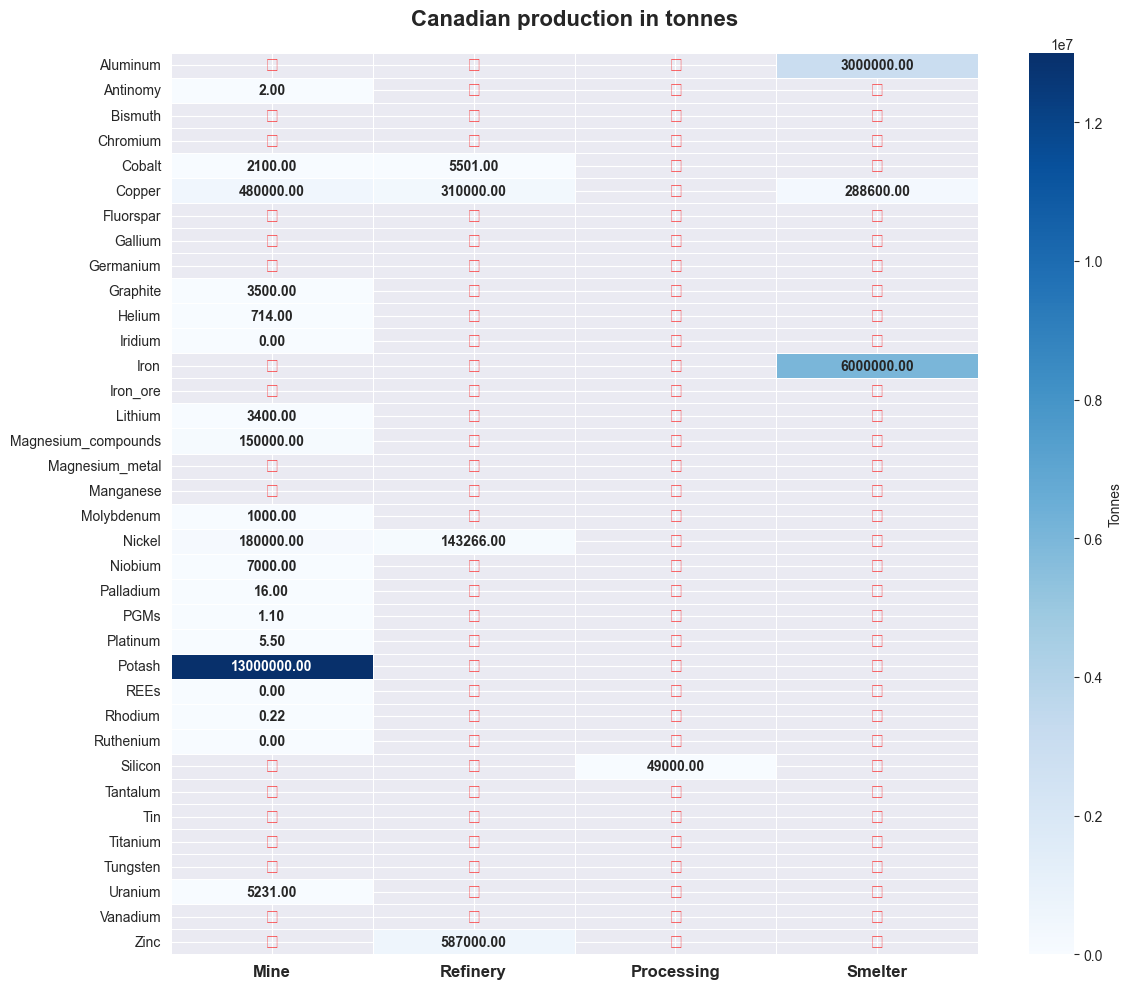

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the relevant columns
values_columns = [
    'Mine Production (Canada)', 
    'Refinery Production (Canada)', 
    'Processing Production (Canada)', 
    'Smelter Production (Canada)'
]

# Extract the relevant columns, keeping NaN values intact
df_values = df[['Commodity'] + values_columns].set_index('Commodity')

# Rename columns for simpler labels
df_values.rename(columns={
    'Mine Production (Canada)': 'Mine', 
    'Refinery Production (Canada)': 'Refinery', 
    'Processing Production (Canada)': 'Processing', 
    'Smelter Production (Canada)': 'Smelter'
}, inplace=True)

# Create the heatmap without filling NaNs, using a mask for NaN cells
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_values, annot=True, cmap="Blues", fmt=".2f", linewidths=.5, cbar_kws={'label': 'Tonnes'},
                      annot_kws={"size": 10, "weight": "bold"}, mask=df_values.isna())

# Overlay crosses on NaN cells by iterating through each cell
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        if pd.isna(df_values.iloc[i, j]):  # Check if the cell is NaN
            heatmap.text(j + 0.5, i + 0.5, '✕', color='red', ha='center', va='center', fontsize=14, fontweight='bold')

# Customize x-axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, fontweight='bold')

# Remove the y-axis label 'Commodity'
heatmap.set_ylabel('')

# Set the title with more space using the 'pad' argument
plt.title('Canadian production in tonnes', fontweight='bold', fontsize=16, pad=20)

# Adjust layout and save the heatmap with high quality
plt.tight_layout()
plt.savefig('graphs/production_heatmap.png', format='png', dpi=300)

# Show the heatmap
plt.show()
